## Introduction

This project is done as part of the final honors assignment in [**Natural Language Processing**](https://www.coursera.org/learn/language-processing) course on Coursera. In this project, I'll be building a conversational chatbot that can understand and respond to natural language questions. My initial approach to this project was to use an attention-based encoder-decoder model. However, I found that the model was too slow to train and the results weren't promising. I then decided to use a transformer model instead since it was much faster to train and is very popular in the NLP community these days. 

This notebook is a step-by-step explanation of how I built the model. The main intent of writing this notebook was actully for me to learn how a transformer model works and how to use it to build a conversational chatbot. I hope you find this notebook useful and that you can use it to build your own chatbot. All the references that I used in this notebook are mentioned in the [References](#references) section.

## Data Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
% cd '/content/drive/MyDrive/Deep Learning/Coursera - Introduction to NLP/Week5/Transformer Chatbot'

/content/drive/MyDrive/Deep Learning/Coursera - Introduction to NLP/Week5/Transformer Chatbot


Importing the necessary libraries and packages needed for the rest of the notebook.

I'm using the contractions library to expand contractions in the dataset instead of manually expanding them (for example "won't" to "will not"). There's actually a much better library for this purpose, which is [pycontractions](https://pypi.org/project/pycontractions/). However, I couldn't install it since it requires a specific old version of Java.

In [ ]:
import nltk
import ast
import os
import sys
import re
import datetime
try:
    import contractions
except:
    ! pip install contractions
    import contractions
from tqdm import tqdm
import dill as pickle
import numpy as np
import dill as pickle
from collections import defaultdict
import xml.etree.ElementTree as ET
from gzip import GzipFile

# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
nltk.download('punkt')
nltk.download('wordnet')

from sklearn.model_selection import train_test_split
# !pip install tensorflow==2.3.1
import tensorflow as tf

# ! conda install -c conda-forge -y pydot graphviz

     |████████████████████████████████| 321 kB 5.1 MB/s 
     |████████████████████████████████| 284 kB 44.7 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85451 sha256=db0aa19d79161d7aea78977691e12a5eb3af3c400b7b9f96b19b8726ca19a339
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Check if the GPU is available with tensorflow.

In [ ]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

The Seq2Seq network might try to allocate the full GPU memory even when it is not needed. This issue can be corrected by the following code.

In [ ]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU {}'.format(tpu.cluster_spec().as_dict()['worker']))
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("REPLICAS: {}".format(strategy.num_replicas_in_sync))

Running on TPU ['10.121.251.154:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.121.251.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.121.251.154:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS: 8


### Utility Functions

The following classes and functions which was provided with the assignment as starter codes are used to extract, clean and preprocess the data.

In [ ]:
"""
    Load the Cornell dialog corpus.
"""
class CornellData:
    def __init__(self, dirName):
        """
        Args:
            dirName (string): directory where to load the corpus
        """
        self.lines = {}
        self.conversations = []

        MOVIE_LINES_FIELDS = ["lineID","characterID","movieID","character","text"]
        MOVIE_CONVERSATIONS_FIELDS = ["character1ID","character2ID","movieID","utteranceIDs"]

        self.lines = self.loadLines(os.path.join(dirName, "movie_lines.txt"), MOVIE_LINES_FIELDS)
        self.conversations = self.loadConversations(os.path.join(dirName, "movie_conversations.txt"), MOVIE_CONVERSATIONS_FIELDS)

        # TODO: Cleaner program (merge copy-paste) !!

    def loadLines(self, fileName, fields):
        """
        Args:
            fileName (str): file to load
            field (set<str>): fields to extract
        Return:
            dict<dict<str>>: the extracted fields for each line
        """
        lines = {}

        with open(fileName, 'r', encoding='iso-8859-1') as f:  # TODO: Solve Iso encoding pb !
            for line in f:
                values = line.split(" +++$+++ ")

                # Extract fields
                lineObj = {}
                for i, field in enumerate(fields):
                    lineObj[field] = values[i]

                lines[lineObj['lineID']] = lineObj

        return lines

    def loadConversations(self, fileName, fields):
        """
        Args:
            fileName (str): file to load
            field (set<str>): fields to extract
        Return:
            list<dict<str>>: the extracted fields for each line
        """
        conversations = []

        with open(fileName, 'r', encoding='iso-8859-1') as f:  # TODO: Solve Iso encoding pb !
            for line in f:
                values = line.split(" +++$+++ ")

                # Extract fields
                convObj = {}
                for i, field in enumerate(fields):
                    convObj[field] = values[i]

                # Convert string to list (convObj["utteranceIDs"] == "['L598485', 'L598486', ...]")
                lineIds = ast.literal_eval(convObj["utteranceIDs"])

                # Reassemble lines
                convObj["lines"] = []
                for lineId in lineIds:
                    convObj["lines"].append(self.lines[lineId])

                conversations.append(convObj)

        return conversations

    def getConversations(self):
        return self.conversations


"""
    Load the opensubtitles dialog corpus.
"""
class OpensubsData:
    """
    """

    def __init__(self, dirName):
        """
        Args:
            dirName (string): directory where to load the corpus
        """

        # Hack this to filter on subset of Opensubtitles
        # dirName = "%s/en/Action" % dirName

        print("Loading OpenSubtitles conversations in %s." % dirName)
        self.conversations = []
        self.tag_re = re.compile(r'(<!--.*?-->|<[^>]*>)')
        self.conversations = self.loadConversations(dirName)

    def loadConversations(self, dirName):
        """
        Args:
            dirName (str): folder to load
        Return:
            array(question, answer): the extracted QA pairs
        """
        conversations = []
        dirList = self.filesInDir(dirName)
        for filepath in tqdm(dirList, "OpenSubtitles data files"):
            if filepath.endswith('xml'):
                try:
                    doc = self.getXML(filepath)
                    conversations.extend(self.genList(doc))
                except ValueError:
                    tqdm.write("Skipping file %s with errors." % filepath)
                except:
                    print("Unexpected error:", sys.exc_info()[0])
                    raise
        return conversations

    def getConversations(self):
        return self.conversations

    def genList(self, tree):
        root = tree.getroot()

        timeFormat = '%H:%M:%S'
        maxDelta = datetime.timedelta(seconds=1)

        startTime = datetime.datetime.min
        strbuf = ''
        sentList = []

        for child in root:
            for elem in child:
                if elem.tag == 'time':
                    elemID = elem.attrib['id']
                    elemVal = elem.attrib['value'][:-4]
                    if elemID[-1] == 'S':
                        startTime = datetime.datetime.strptime(elemVal, timeFormat)
                    else:
                        sentList.append((strbuf.strip(), startTime, datetime.datetime.strptime(elemVal, timeFormat)))
                        strbuf = ''
                else:
                    try:
                        strbuf = strbuf + " " + elem.text
                    except:
                        pass

        conversations = []
        for idx in range(0, len(sentList) - 1):
            cur = sentList[idx]
            nxt = sentList[idx + 1]
            if nxt[1] - cur[2] <= maxDelta and cur and nxt:
                tmp = {}
                tmp["lines"] = []
                tmp["lines"].append(self.getLine(cur[0]))
                tmp["lines"].append(self.getLine(nxt[0]))
                if self.filter(tmp):
                    conversations.append(tmp)

        return conversations

    def getLine(self, sentence):
        line = {}
        line["text"] = self.tag_re.sub('', sentence).replace('\\\'','\'').strip().lower()
        return line

    def filter(self, lines):
        # Use the followint to customize filtering of QA pairs
        #
        # startwords = ("what", "how", "when", "why", "where", "do", "did", "is", "are", "can", "could", "would", "will")
        # question = lines["lines"][0]["text"]
        # if not question.endswith('?'):
        #     return False
        # if not question.split(' ')[0] in startwords:
        #     return False
        #
        return True

    def getXML(self, filepath):
        fext = os.path.splitext(filepath)[1]
        if fext == '.gz':
            tmp = GzipFile(filename=filepath)
            return ET.parse(tmp)
        else:
            return ET.parse(filepath)

    def filesInDir(self, dirname):
        result = []
        for dirpath, dirs, files in os.walk(dirname):
            for filename in files:
                fname = os.path.join(dirpath, filename)
                result.append(fname)
        return result


def extractText(text, fast_preprocessing=True):
    if fast_preprocessing:
        GOOD_SYMBOLS_RE = re.compile('[^0-9a-z ]')
        REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;#+_]')
        REPLACE_SEVERAL_SPACES = re.compile('\s+')

        text = text.lower()
        text = REPLACE_BY_SPACE_RE.sub(' ', text)
        text = GOOD_SYMBOLS_RE.sub('', text)
        text = REPLACE_SEVERAL_SPACES.sub(' ', text)
        return text.strip()
    else:
        text = text.lower()

        REMOVE_HYPHENS_RE = re.compile('-(?!\w)|(?<!\w)-')
        REPLACE_SEVERAL_SPACES = re.compile('\s+')

        # Remove any html/xml tag
        text = re.sub(r'<.*?>', '', text)
        text = text.replace("...", " ")
        text = text.replace("..", " ")
        text = text.replace(" - ", '. ')
        # Remove hyphens but keep hyphernated-words.
        text = REMOVE_HYPHENS_RE.sub('', text)

        text = contractions.fix(text)
    
        # Separate punctuations to reduce unecassery vocabs
        text = text.replace("?", " ?")
        text = text.replace("!", " !")
        text = text.replace(".", " .")
        text = text.replace(",", " ,")
        text = re.sub(r"didn'", "did not", text)
        text = re.sub(r"'bout", "about", text)
        text = re.sub(r"'til", "until", text)
        text = re.sub(r"'tis", "it is", text)
        
        # Replace tryin' into trying but don't replace man's into mangs
        text = re.sub(r"n'[^s]", "ng", text)

        text = re.sub(r"[^a-z0-9,.?!' ]+", '', text)

        text = REPLACE_SEVERAL_SPACES.sub(' ', text)

        return text.strip()


def extractConversations(conversations, max_len=15, fast_preprocessing=True):
    data = []
    for conversation in tqdm(conversations):
        lines = conversation['lines']
        for i in range(len(lines) - 1):
            request = extractText(lines[i]['text'], fast_preprocessing)
            reply = extractText(lines[i + 1]['text'], fast_preprocessing)

            if 0 < len(request.split()) <= max_len and 0 < len(reply.split()) <= max_len:
                data += [request, reply]
    return data


def readCornellData(path, max_len=15, fast_preprocessing=True):
    dataset = CornellData(path)
    conversations = dataset.getConversations()
    return extractConversations(conversations, max_len=max_len, fast_preprocessing=fast_preprocessing)


def readOpensubsData(path, max_len=15, fast_preprocessing=True):
    dataset = OpensubsData(path)
    conversations = dataset.getConversations()
    return extractConversations(conversations, max_len=max_len, fast_preprocessing=fast_preprocessing)


def prepare_data(save_path, data=None):
    dialogues = []
    if os.path.isfile(save_path):
        with open(save_path, 'rb') as f:
            dialogues = pickle.load(f)
    else:
        print("Preparing data...")
        for i in tqdm(range(0, len(data), 2)):
            dialogues += [(data[i], data[i + 1])]
        print("Saving source, target pairs...")
        with open(save_path, 'wb') as f:
            pickle.dump(dialogues, f)

    return dialogues


def prepare_vocabularies(vocab_path, data, special_tokens, vocab_size=25000, oov_id=1):
    vocab = defaultdict(int)
    maxlen = 0
    total_source_words, total_target_words = 0, 0
    if os.path.isfile(f'{vocab_path}.pkl'):
        with open(f'{vocab_path}.pkl', 'rb') as f:
            [total_words, maxlen, tok2id, vocab] = pickle.load(f)
    else:
        for enc_sent, dec_sent in tqdm(data, "Preparing vocabulary"):
            enc_sent, dec_sent = enc_sent.split(), dec_sent.split()
            maxlen = max(maxlen, len(enc_sent))
            maxlen = max(maxlen, len(dec_sent))
            for enc_word, dec_word in zip(enc_sent, dec_sent):
                if enc_word not in vocab:
                    total_source_words += 1
                    vocab[enc_word] += 1
                if dec_word not in vocab: 
                    total_target_words += 1
                    vocab[dec_word] += 1

        vocab = special_tokens + sorted(vocab, key=vocab.get, reverse=True)
        if len(vocab) > vocab_size:
            vocab = vocab[:vocab_size]

        tok2id = defaultdict(lambda:oov_id, {tok: i for i, tok in enumerate(vocab)})

        total_words = total_source_words + total_target_words

        with open(f'{vocab_path}.pkl', 'wb') as f:
            pickle.dump([total_words, maxlen, tok2id, vocab], f)

    return total_words, maxlen, tok2id, vocab


def preprocess_sentence(sentence, fast_preprocessing=True):
    return '<START> ' + extractText(sentence, fast_preprocessing) + ' <END>'


def sentence_to_ids(sentence, tok2id):
    return [tok2id[word] for word in sentence.split()]


def ids_to_sentence(ids, id2tok):
    return [id2tok[id] for id in ids]


def tokens_to_padded_ids(conversations, tok2id, max_len, start_token='<START>', end_token='<END>'):
    source_ids, target_ids = [], []
    for source, target in conversations:
        source_ids.append(sentence_to_ids(start_token + ' ' + source + ' ' + end_token, tok2id))
        target_ids.append(sentence_to_ids(start_token + ' ' + target + ' ' + end_token, tok2id))
    source_ids = tf.keras.preprocessing.sequence.pad_sequences(source_ids, padding='post', maxlen=max_len, dtype='int32')
    target_ids = tf.keras.preprocessing.sequence.pad_sequences(target_ids, padding='post', maxlen=max_len, dtype='int32')
    return source_ids, target_ids

### Reading and Preprocessing the data

First, we will read the data from the files and normalize them. The processed data are then merged into a single list. The following code will not be needed after the dialogues are dumped into a file.

In [ ]:
conversations = None
if not os.path.isfile('./metadata/conversations.pkl'):
    cornellData = readCornellData('data/cornell', fast_preprocessing=False)
    opensubsData = readOpensubsData('data/opensubs', fast_preprocessing=False)
    conversations = cornellData + opensubsData
    print(f'Data size: {len(conversations)}')

Prepare (source, target) pairs from the above normalized sentences.

In [ ]:
dialogue_data = prepare_data('metadata/conversations.pkl', conversations)

In [ ]:
dialogue_data[:5]

[('not the hacking and gagging and spitting part . please .',
  'okay then how about we try out some french cuisine . saturday ? night ?'),
 ('no , no , it is my fault we did not have a proper introduction',
  'cameron .'),
 ('gosh , if only we could find kat a boyfriend',
  'let me see what i can do .'),
 ("c'esc ma tete . this is my head",
  'right . see ? you are ready for the quiz .'),
 ('that is because it is such a nice one .', 'forget french .')]

Let's define the special tokens. Note that the &lt;PAD&gt; token is put at the beginning of the vocabulary so that it is the index 0.

In [ ]:
special_tokens = ['<PAD>', '<UNK>', '<START>', '<END>']

Splitting the data into training and validation sets.

In [ ]:
train_dialogues, val_dialogues = train_test_split(dialogue_data[:160000], test_size=0.2, random_state=23)
print(f'Train set size: {len(train_dialogues)}')
print(f'Validation set size: {len(val_dialogues)}')

Train set size: 128000
Validation set size: 32000


In [ ]:
train_dialogues[:5]

[('you think about your father a lot , do not you ?', 'yes mam'),
 ('crown victoria . f .b .i . car . a legitimate tail .', 'as opposed to ?'),
 ('and if people ask me why i am so humane',
  'i say that i know the taste of love .'),
 ('mr . carpenter , i goodnight .', 'goodnight , my dear .'),
 ('i do not understand . . i do not understand .',
  'you chose to become a test subject . many years ago .')]

Now let's prepare and save the vocabularies for the encoder and decoder (For a training set of 128k source, target sentence pairs).

In [ ]:
total_words, max_len, tok2id, id2tok = prepare_vocabularies('metadata/vocab', train_dialogues, special_tokens, vocab_size=30000)

In [ ]:
print(f'Vocabulary size: {len(tok2id)}')

Vocabulary size: 30000


In [ ]:
print(f'Maximum words in a sentence: {max_len}')

Maximum words in a sentence: 15


In [ ]:
print(f'Total unique words in the corpus: {total_words}')

Total unique words in the corpus: 31498


In [ ]:
print(f'Percentage of unknown words in train set: {(total_words - len(tok2id)) / total_words * 100}%')

Percentage of unknown words in train set: 4.755857514762842%


As it can be seen in the above cell, the vocabulary size (30,000 in this case) is chosen such that the unknown word percentage in the training corpus is less than 5%.

#### Creating tf.data.Dataset

Let's first define some hyperparameters for the tf.data.Dataset.

In [ ]:
VOCAB_SIZE = len(tok2id)
BATCH_SIZE = 64 * strategy.num_replicas_in_sync
BUFFER_SIZE = 20000

To utilize features such as caching and prefetching which speed up the training process, we will use the tf.data.Dataset class.

`target_ids` is divided into `dec_inputs` and `outputs` which are the ground truth values for calculating loss and accuracy.

In [ ]:
source_ids, target_ids = tokens_to_padded_ids(train_dialogues, tok2id, max_len)
val_source_ids, val_target_ids = tokens_to_padded_ids(val_dialogues, tok2id, max_len)

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': source_ids,
        'dec_inputs': target_ids[:, :-1]
    },
    {
        'outputs': target_ids[:, 1:]
    }
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': val_source_ids,
        'dec_inputs': val_target_ids[:, :-1]
    },
    {
        'outputs': val_target_ids[:, 1:]
    }
))

val_dataset = val_dataset.cache()
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
source_ids.shape

(128000, 15)

In [ ]:
target_ids.shape

(128000, 15)

In [ ]:
dataset

<PrefetchDataset shapes: ({inputs: (None, 15), dec_inputs: (None, 14)}, {outputs: (None, 14)}), types: ({inputs: tf.int32, dec_inputs: tf.int32}, {outputs: tf.int32})>

## The Transformer Model (Attention Is All You Need)

"Most competitive neural sequence transduction models have an encoder-decoder structure.
Here, the encoder maps an input sequence of symbol representations (x1, ..., xn) to a sequence
of continuous representations z = (z1, ..., zn). Given **z**, the decoder then generates an output
sequence (y1, ..., ym) of symbols one element at a time. At each step the model is auto-regressive
, consuming the previously generated symbols as additional input when generating the next.

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully
connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1,
respectively."

[ Vaswani, Ashish & Shazeer, Noam & Parmar, et al., 2017. Attention Is All You Need. page 2 ](https://arxiv.org/pdf/1706.03762.pdf)

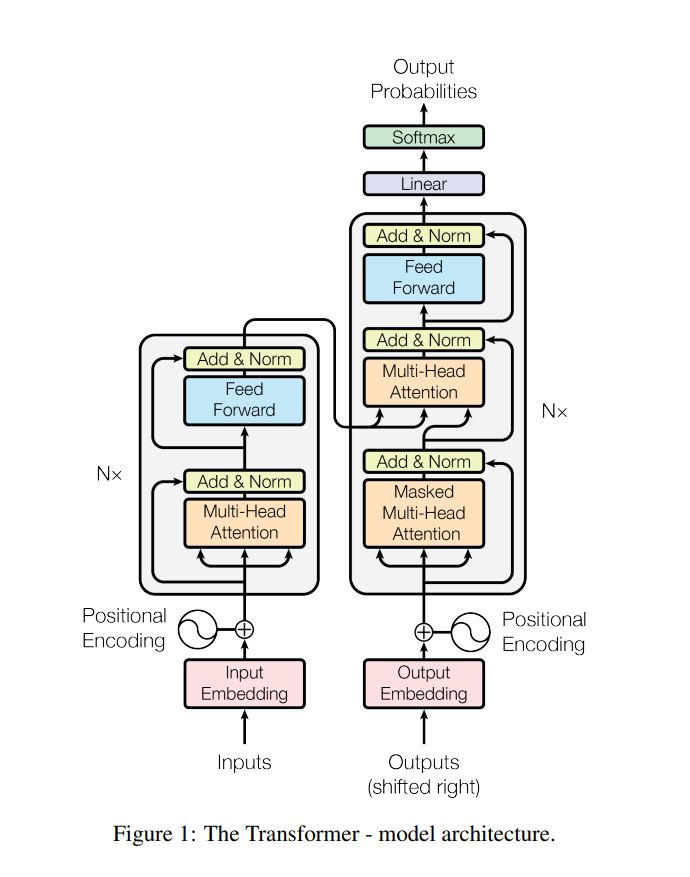

We can observe there is an encoder model on the left side and the decoder on the right one. Both contains a core block of “an attention and a feed-forward network” repeated N times. But first we need to explore a core concept in transformer network: the self-attention mechanism.

### Self-Attention

"An attention function can be described as mapping a query and a set of key-value pairs to an output,
where the query, keys, values, and output are all vectors. The output is computed as a weighted sum
of the values, where the weight assigned to each value is computed by a compatibility function of the
query with the corresponding key."

[ Vaswani, Ashish & Shazeer, Noam & Parmar, et al., 2017. Attention Is All You Need. page 3 ](https://arxiv.org/pdf/1706.03762.pdf)

Instead of paying attention to the last state of the encoder as is done usually with RNNs, what the attention does is basically "looking at" all the states of the encoder which gives the ability to access the information about all the elements of the input sequence.

But with this approach, since each sequence must be treated one element at a time, it'll be time consuming and computationally expensive for huge corpus as both the encoder and decoder have to wait until the completion of `t-1` steps before processing the `t`th step.


However, the Transformer model does this brilliantly by extracting features for each word using a `self-attention` mechanism to **figure out how important all the words in the sequence are** w.r.t. the current word. Since these are just weighted sums and activations, they can be parallelized to speed up the computation.

Before deep diving into self-attention, let's first look at the three elements of it: the `query`, `key` and `value`.

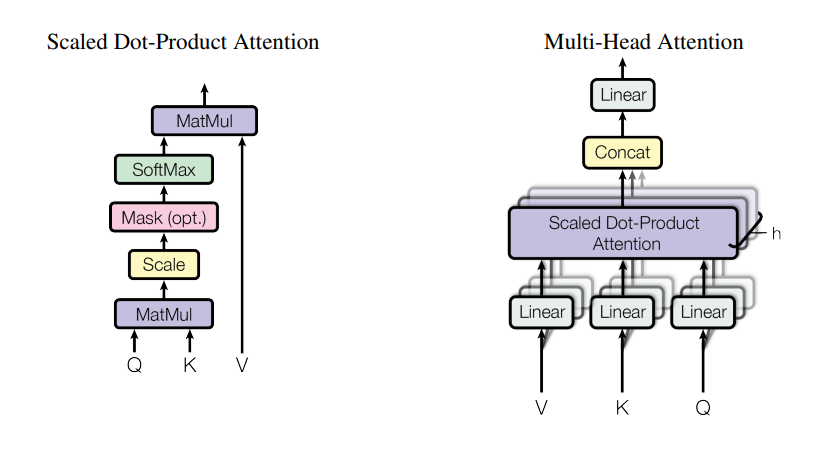![](images/attention.png)

The `query`, `key` and the `value` are actually three linear transformations of the encoders input vectors x<sub>i</sub> (embedding of each input word):

$$q_i = W_qx_i$$
$$k_i = W_kx_i$$
$$v_i = W_vx_i$$

<img src="https://jalammar.github.io/images/t/transformer_self_attention_vectors.png" />

The above vector equations can be condesed into three matrices: Q, K and V by stacking the embeddings for each word in a single input sentence together as following:

<img src="https://jalammar.github.io/images/t/self-attention-matrix-calculation.png" />

#### Scaled dot product Attention

The scaled dot-product attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

The multiplication of the queries with the keys gives the relevance score between each input word and output word.

<img src="https://jalammar.github.io/images/t/self-attention-matrix-calculation-2.png" />

As the softmax normalization is done on the `key`, its values decide the amount of importance given to the `query`.

The output represents the multiplication of the attention weights and the `value` vector. This ensures that the words we want to focus on are kept as is and the irrelevant words are flushed out. Following is a nice visualization explaining the reason for multiplying the attention weights with the value matrix. The intuition can be thought in terms of computer vision: When we look at a frame, our brains instantly filters out all the unnecessary information in the background of the frame so that we can **pay attention** to the important details.

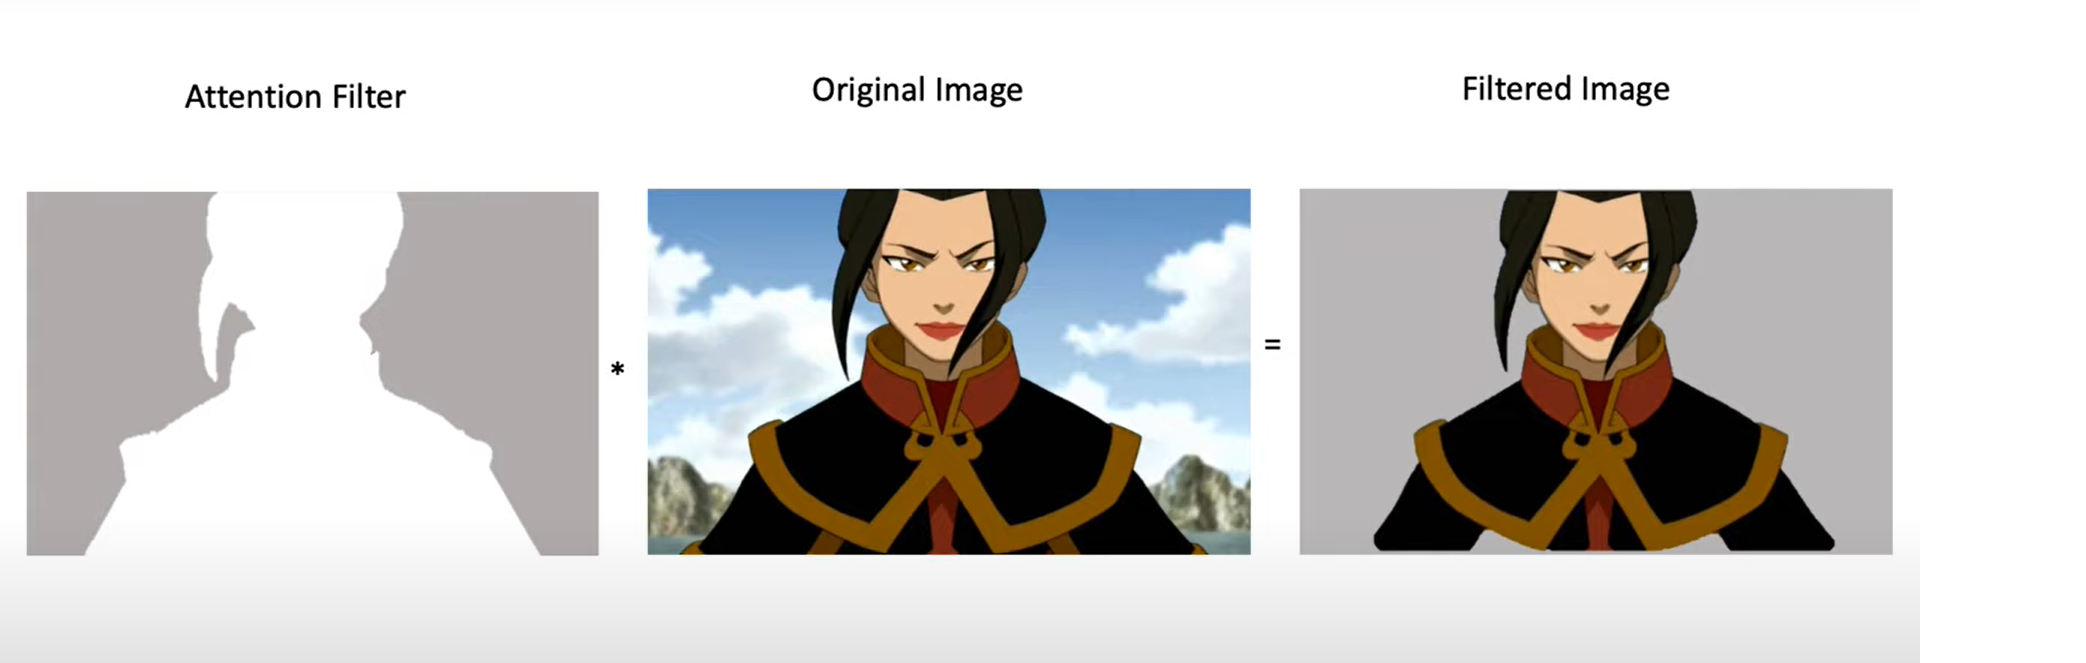

The above image is analogous to the following:

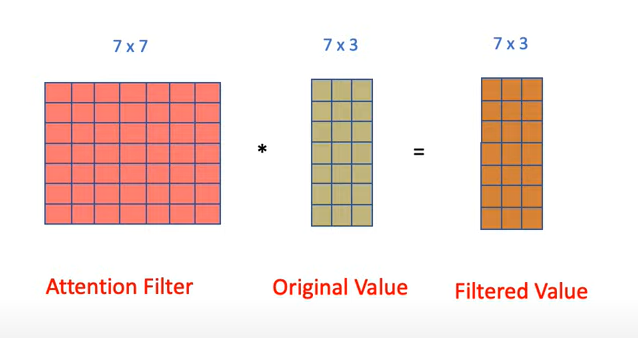

The dot-product attention is scaled by a factor of square root of the embedding_dim. This is done because for large values of embedding_dim, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `query` and `key` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `query` and `key` should have a mean of 0 and variance of 1, so that we get a gentler softmax.

The mask is multiplied with *-1e9 (close to negative infinity).* This is done because the mask is summed with the scaled matrix multiplication of `query` and `key` and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [ ]:
def scaled_dot_product_attention(query, key, value, mask):
    """Calculate the attention weights. """
    # Compute the cosine similarity between query and key. Since they're matrices, the last matrix has to be transposed.
    product = tf.matmul(query, key, transpose_b=True)
    embedding_dim = tf.cast(tf.shape(key)[-1], tf.float32)
    # Scale the dot product.
    logits = product / tf.math.sqrt(embedding_dim)
    # Mask out the paddings.
    if mask is not None: logits += (mask * -1e9)
    # Apply softmax over the last axis.
    attention_weights = tf.nn.softmax(logits, axis=-1)
    # Multiply the weights with values.
    return tf.matmul(attention_weights, value)

#### Multi-head attention

Multi-head attention consists of four parts:
* Linear layers and split into heads.
* Scaled dot-product attention.
* Concatenation of heads.
* Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, `query`, `key`, and `value` are split into multiple heads because it allows the model to **jointly attend to information at different positions** from **different representational spaces** (For example one head may learn the grammar, another may learn genders, vocabulary, etc.). After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

<img src="https://jalammar.github.io/images/t/transformer_multi-headed_self-attention-recap.png" />

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, embedding_dim, num_heads, name='multi-head_attention'):
        super(MultiHeadAttention, self).__init__(name=name)
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads

        assert self.embedding_dim % self.num_heads == 0

        self.depth = self.embedding_dim // self.num_heads

        self.query_dense = tf.keras.layers.Dense(self.embedding_dim)
        self.key_dense = tf.keras.layers.Dense(self.embedding_dim)
        self.value_dense = tf.keras.layers.Dense(self.embedding_dim)

        self.dense = tf.keras.layers.Dense(self.embedding_dim)

    def split_heads(self, inputs, batch_size):
        inputs = tf.keras.layers.Lambda(lambda x: tf.reshape(x, shape=(batch_size, -1, self.num_heads, self.depth)))(inputs)
        return tf.keras.layers.Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3]))(inputs)

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            'embedding_dim': self.embedding_dim,
            'num_heads': self.num_heads
        })
        return config

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]
        # Linear layers (passing the inputs through linear layers without an activation does two things: mapping inputs to outputs, changing the dimensions of the inputs).
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        # Split heads.
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        # Scaled dot-product attention.
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.keras.layers.Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3]))(scaled_attention)
        # Concatenating the heads.
        concatenated_attention = tf.keras.layers.Lambda(lambda x: tf.reshape(x, shape=(batch_size, -1, self.embedding_dim)))(scaled_attention)
        # Apply the final linear layer.
        return self.dense(concatenated_attention)

### Masking

The following utility functions will be used to mask out the padding tokens and mask out the future tokens from the input.

The `create_look_ahead_mask` utility function which masks out the future tokens is needed for the first multi-head attention layer in the **autoregressive** (the decoder predicts tokens based on the previous outputs as well as the encoder outputs that contain the attention information from the input) decoder.

In [ ]:
def create_padding_mask(x, padding_id=0):
    mask = tf.cast(tf.math.equal(x, padding_id), tf.float32)
    # Shape: (batch_size, 1, 1, sequence_length)
    # tf.newaxis is similar to tf.expand_dims
    return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x, padding_id=0):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x, padding_id)
    return tf.maximum(look_ahead_mask, padding_mask)

### Positional Encoding

Since the transformer model doesn't contain any recurrence or convolution, we loose the sequence nature of the model or the order of the input sequence. If it was a LSTM, it takes the input word embeddings sequentially in their designated order. Thus the LSTM knows which word came first, which word came second. But, the transformer network and the self-attention mechanism is permutation invariant. It takes all the embeddings at once. If we shuffle up the words in the input sentence, we get the same solutions. Even though this is a huge plus point since the model can take inputs faster, it is a huge downside since the model can't learn the order of the words.

To address this, the transformer model adds a vector with same dimensions as the word embeddings known as the **positional encoding** to each input embedding. These vectors follow a specific pattern that the model learns, which helps it determine the position of each word or the distance between different words in the sequence. Word embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other in this space. They do not encode the relative position of words in a sentence. But when the positional encodings are added, word embeddings will be closer to each other based on the similarity of their meaning as well as their relative position in the sentence in the d-dimensional space. These embeddings will provide meaningful distances between the embedding vectors once they're projected into Query, Key and Value vectors during dot-product attention (the resultant embeddings are **position-aware embeddings**).

So, we apply a function to map the position in the sentence to a real valued vector. The network will learn how to use this information. The paper uses a sinusoidal function to map the position to a vector (it adds frequency information to the embeddings):

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

Even though the values can be identical at two positions at lower frequencies, the use of multiple frequencies per dimension makes them have different values at higher frequencies as follows:

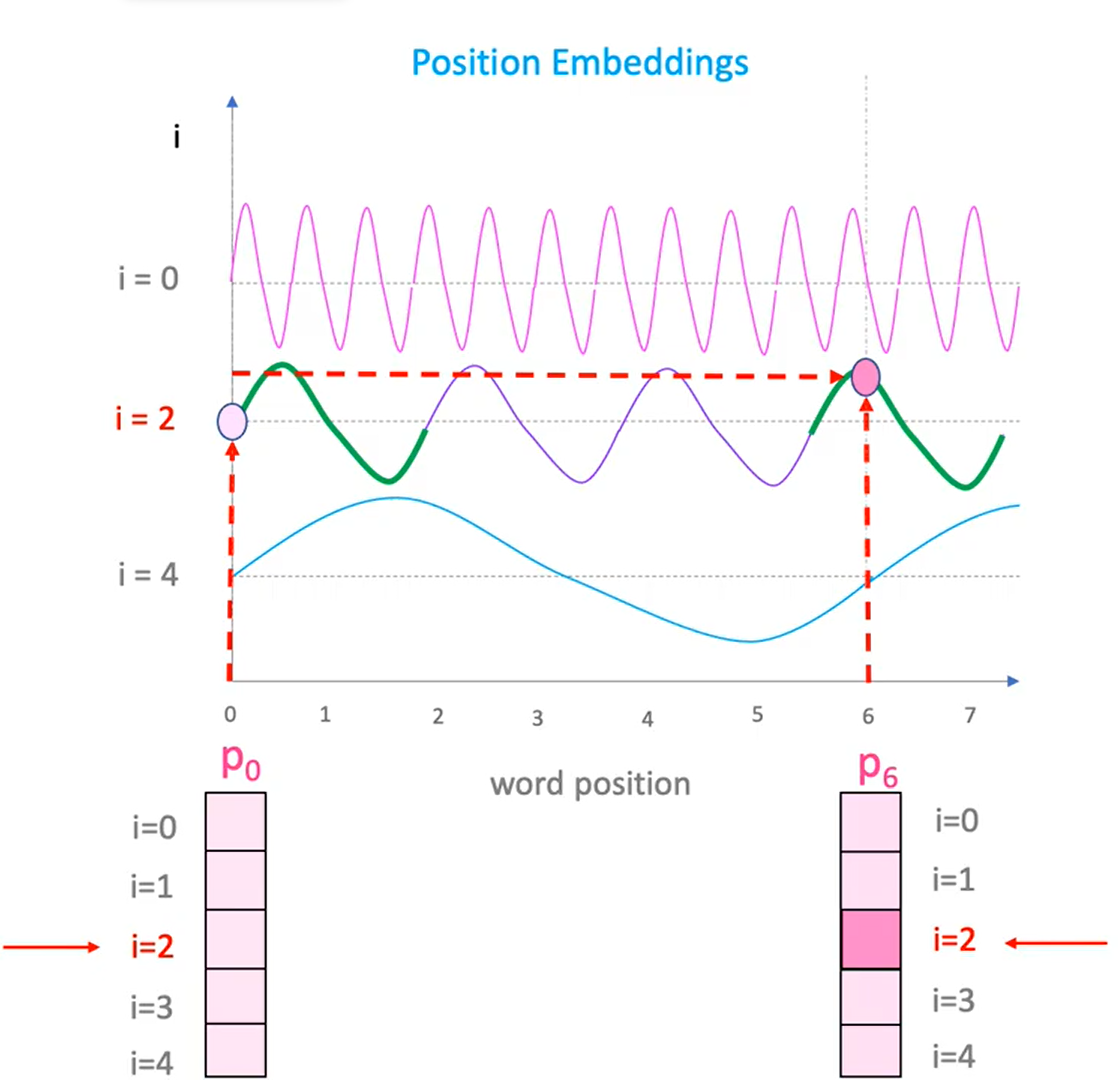

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim):
        super(PositionalEncoding, self).__init__()
        self.embedding_dim = embedding_dim
        self.vocab_size = vocab_size
        self.pos_encoding = self.positional_encoding(vocab_size)

    def get_config(self):
        config = super(PositionalEncoding, self).get_config()
        config.update({
            'embedding_dim': self.embedding_dim,
            'position': self.vocab_size
        })
        return config

    def get_angles(self, position, i):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(self.embedding_dim, tf.float32))
        return position * angles

    def positional_encoding(self, position):
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(self.embedding_dim, dtype=tf.float32)[tf.newaxis, :])
        # Apply sin to even indices in the array;
        sines = tf.math.sin(angle_rads[:, 0::2])
        # Apply cos to odd indices in the array.
        cosines = tf.math.cos(angle_rads[:, 1::2])
        # Concatenate the two halves.
        pos_encoding = tf.concat([sines, cosines], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    @tf.autograph.experimental.do_not_convert
    def call(self, inputs, training=False):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

The following is a visualization of the positional encoding pattern. Each row corresponds to a positional encoding of a vector. Each row contains 512 values ranging from -1 to 1. The first row corresponds to the first word in the sentence, the second row corresponds to the second word, and so on.

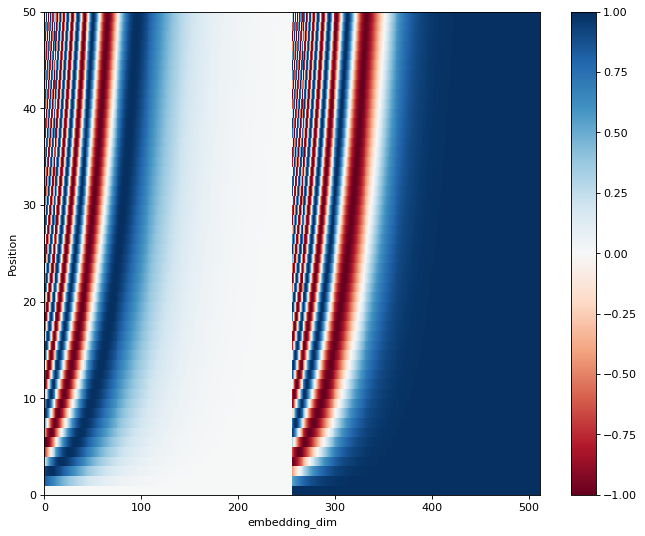

In [ ]:
test_pos_encoding = PositionalEncoding(50, 512)

plt.figure(figsize=(10, 8), dpi=80)
plt.pcolormesh(test_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('embedding_dim')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

The split in half down center of the above diagram is due to the use of two functions namely sine and cosine to generate left and the right halves respectively and then they're concatenated. However, in the original paper, they do not concatenate the two halves. Instead, they interweave the two signals.

### Encoder Layer

There are two major components per each encoder layer as it can be seen in the high level diagram of the transformer model:
1. A multi-head self attention mechanism.
2. A feed-forward network (which is just a linear / dense layer with ReLU activation) followed by dropout.

There's a **residual connection** around each layer, summing up the output of the layer with its input, followed by a **layer normalization**. The residual connections provide two main purposes:
1. Knowledge Preservation.
2. Avoid vanishing gradients problem.

<img src="https://jalammar.github.io/images/t/transformer_resideual_layer_norm_2.png" />

In [ ]:
def encoder_layer(num_units, embedding_dim, num_heads, dropout, name='encoder_layer'):
    inputs = tf.keras.Input(shape=(None, embedding_dim), name='inputs')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    # Multi-head self-attention layer.
    attention = MultiHeadAttention(embedding_dim, num_heads, name='attention')({
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': padding_mask
    })
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    # Residual connection.
    attention = tf.keras.layers.add([inputs, attention])
    # Normalization layer.
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention)

    # Feed forward layer.
    intermediate = tf.keras.layers.Dense(num_units, activation='relu')(attention)
    intermediate = tf.keras.layers.Dense(embedding_dim)(intermediate)
    intermediate = tf.keras.layers.Dropout(rate=dropout)(intermediate)
    # Residual connection.
    outputs = tf.keras.layers.add([attention, intermediate])
    # Normalization layer.
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs)
    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

Testing and visualizing an encoder layer:

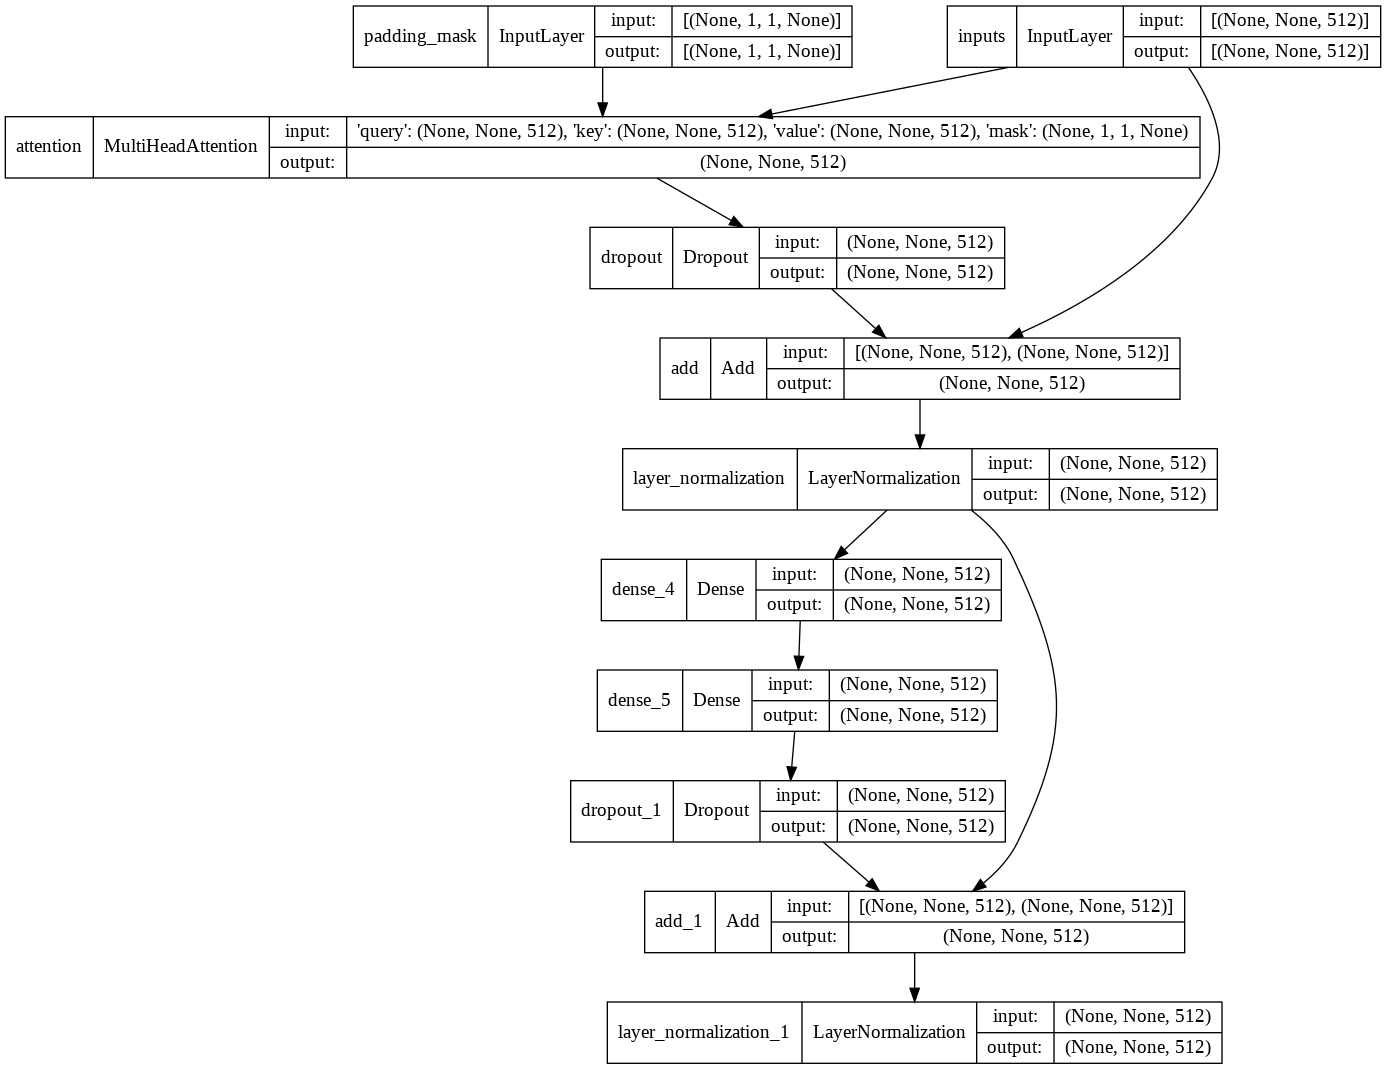

In [ ]:
test_encoder_layer = encoder_layer(num_units=512, embedding_dim=512, num_heads=8, dropout=0.1, name='test_encoder_layer')
tf.keras.utils.plot_model(test_encoder_layer, show_shapes=True)

### Encoder

As discussed previously, the encoder is composed of:
1. Input Embeddings.
2. Positional Encoding.
3. A stack of `num_layers` of encoder layers.

In [ ]:
def encoder(num_layers, num_units, embedding_dim, num_heads, vocab_size, dropout, name='encoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, embedding_dim)(inputs)
    embeddings *= tf.keras.layers.Lambda(lambda d: tf.math.sqrt(tf.cast(d, tf.float32)))(embedding_dim)
    embeddings = PositionalEncoding(vocab_size, embedding_dim)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = encoder_layer(num_units=num_units,
                                embedding_dim=embedding_dim,
                                num_heads=num_heads,
                                dropout=dropout,
                                name=f'encoder_layer_{i}')([outputs, padding_mask])

    return tf.keras.Model(inputs=[inputs, padding_mask], outputs=outputs, name=name)

### Decoder Layer

The decoder takes two kinds of inputs:
1. The output of the top encoder.
2. The next target word of the output text that has been generated so far.

Following are some nice animations of the transformer network data flow for an input sentence. At each time step except the first, the decoder takes both the inputs mentioned above. The encoder output is split into two matrices: Key and Value. The first word we feed into the decoder is actually the `<START>` token.

<img src="https://jalammar.github.io/images/t/transformer_decoding_1.gif" />
<img src="https://jalammar.github.io/images/t/transformer_decoding_2.gif" />

After the first time step, the output of each step is fed to the bottom decoder in the next time step, and the decoders bubble up their decoding results just like the encoders did. Just like it was done in the encoder, those input embeddings are added with positional embeddings to indicate the position of each word.

Each decoder layer consists of the following sub-layers:
1. Multi-head attention with both look ahead and padding masks.
2. Multi-head attention with padding mask.
3. Two dense layers followed by dropout.

The Masked Multi-head attention or **masked causal attention** prevents positions from attending to subsequent positions. It ensures that the predictions for position i can depend only on the known outputs at positions less than i.

The query matrix for the second multi-head attention layer is recieved as the output of the first multi-head attention layer. Each of these sublayers has a residual connection around it followed by a layer normalization. Since the `Key` is arriving from the encoder output and the `Query` is arriving from the previous output of the decoder, the attention weights represent the importance given to the decoder's input **based on the encoder's output**. (The decoder predicts the next word by looking at the encoder output and self-attending to its own input)

In [ ]:
def decoder_layer(num_units, embedding_dim, num_heads, dropout, name='decoder_layer'):
    inputs = tf.keras.Input(shape=(None, embedding_dim), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, embedding_dim), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # Multi-head self-attention layer with look-ahead masking and padding mask.
    attention_1 = MultiHeadAttention(embedding_dim, num_heads, name='attention_1')(inputs={
        'query': inputs,
        'key': inputs,
        'value': inputs,
        'mask': look_ahead_mask
    })
    # Residual connection.
    attention_1 = tf.keras.layers.add([attention_1, inputs])
    # Normalization layer.
    attention_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_1)

    # Multi-head self-attention layer with padding mask.
    attention_2 = MultiHeadAttention(embedding_dim, num_heads, name='attention_2')(inputs={
        'query': attention_1,
        'key': enc_outputs,
        'value': enc_outputs,
        'mask': padding_mask
    })
    attention_2 = tf.keras.layers.Dropout(rate=dropout)(attention_2)
    # Residual connection.
    attention_2 = tf.keras.layers.add([attention_2, attention_1])
    # Normalization layer.
    attention_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention_2)

    # Feed forward layer.
    intermediate = tf.keras.layers.Dense(num_units, activation='relu')(attention_2)
    intermediate = tf.keras.layers.Dense(embedding_dim)(intermediate)
    intermediate = tf.keras.layers.Dropout(rate=dropout)(intermediate)
    # Residual connection.
    outputs = tf.keras.layers.add([intermediate, attention_2])
    # Normalization layer.
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(outputs)

    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

Testing and visualizing a decoder layer:

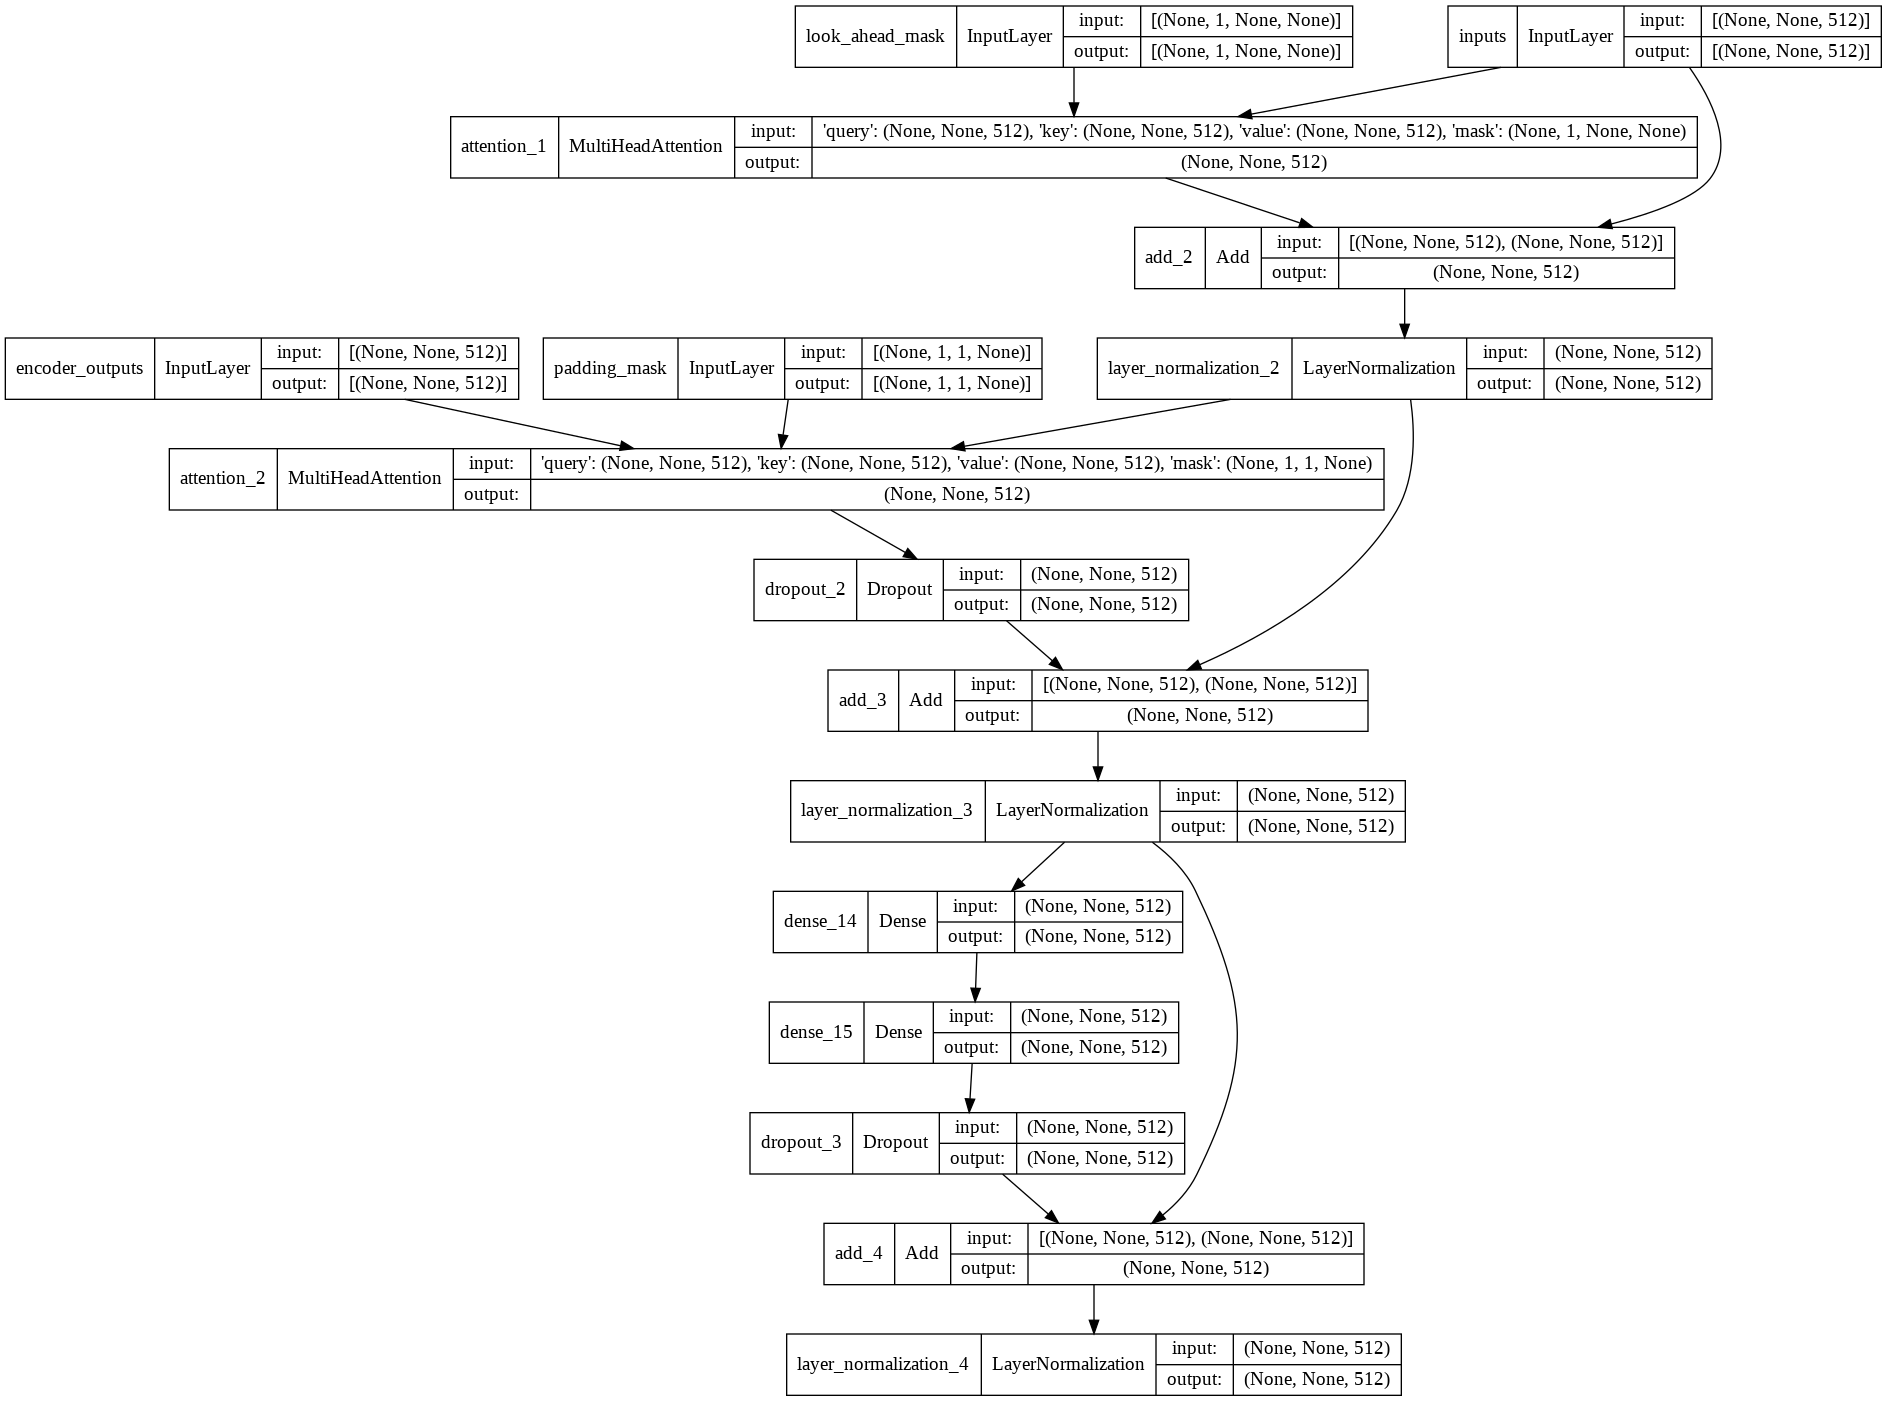

In [ ]:
test_decoder_layer = decoder_layer(num_units=512, embedding_dim=512, num_heads=8, dropout=0.1, name='test_decoder_layer')
tf.keras.utils.plot_model(test_decoder_layer, show_shapes=True)

### Decoder

The Decoder is composed of:
1. Output Embeddings.
2. Positional Encoding.
3. A stack of `num_layers` of decoder layers.

The target next word is fed through an embedding summed with positional encoding. The output of this summation is the input to the decoder. The output of the decoder is the input to the final linear layer.

In [ ]:
def decoder(num_layers, num_units, embedding_dim, num_heads, vocab_size, dropout, name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, embedding_dim), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    embeddings = tf.keras.layers.Embedding(vocab_size, embedding_dim)(inputs)
    embeddings *= tf.keras.layers.Lambda(lambda d: tf.math.sqrt(tf.cast(d, tf.float32)))(embedding_dim)
    embeddings = PositionalEncoding(vocab_size, embedding_dim)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(num_units=num_units,
                                embedding_dim=embedding_dim,
                                num_heads=num_heads,
                                dropout=dropout,
                                name=f'decoder_layer_{i}')(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])
    
    return tf.keras.Model(inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask], outputs=outputs, name=name)

### The Transformer

Now that we have the encoder and decoder, we can create the transformer model. The transformer model is composed of:
1. An encoder.
2. A decoder.
3. A final linear layer.

In [ ]:
def transformer(num_layers, num_units, embedding_dim, num_heads, vocab_size, dropout, name='transformer'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    dec_inputs = tf.keras.Input(shape=(None,), name='dec_inputs')
    enc_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='enc_padding_mask')(inputs)
    # Masking all the tokens except the so far generated tokens (tokens that are to be fed ahead of time).
    look_ahead_mask = tf.keras.layers.Lambda(create_look_ahead_mask, output_shape=(1, None, None), name='look_ahead_mask')(dec_inputs)
    # Masking the padding tokens from the encoder outputs.
    dec_padding_mask = tf.keras.layers.Lambda(create_padding_mask, output_shape=(1, 1, None), name='dec_padding_mask')(inputs)

    enc_outputs = encoder(num_layers, num_units, embedding_dim, num_heads, vocab_size, dropout)(inputs=[inputs, enc_padding_mask])
    dec_outputs = decoder(num_layers, num_units, embedding_dim, num_heads, vocab_size, dropout)(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    outputs = tf.keras.layers.Dense(vocab_size, name='outputs')(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

Testing and visualizing the transformer model:

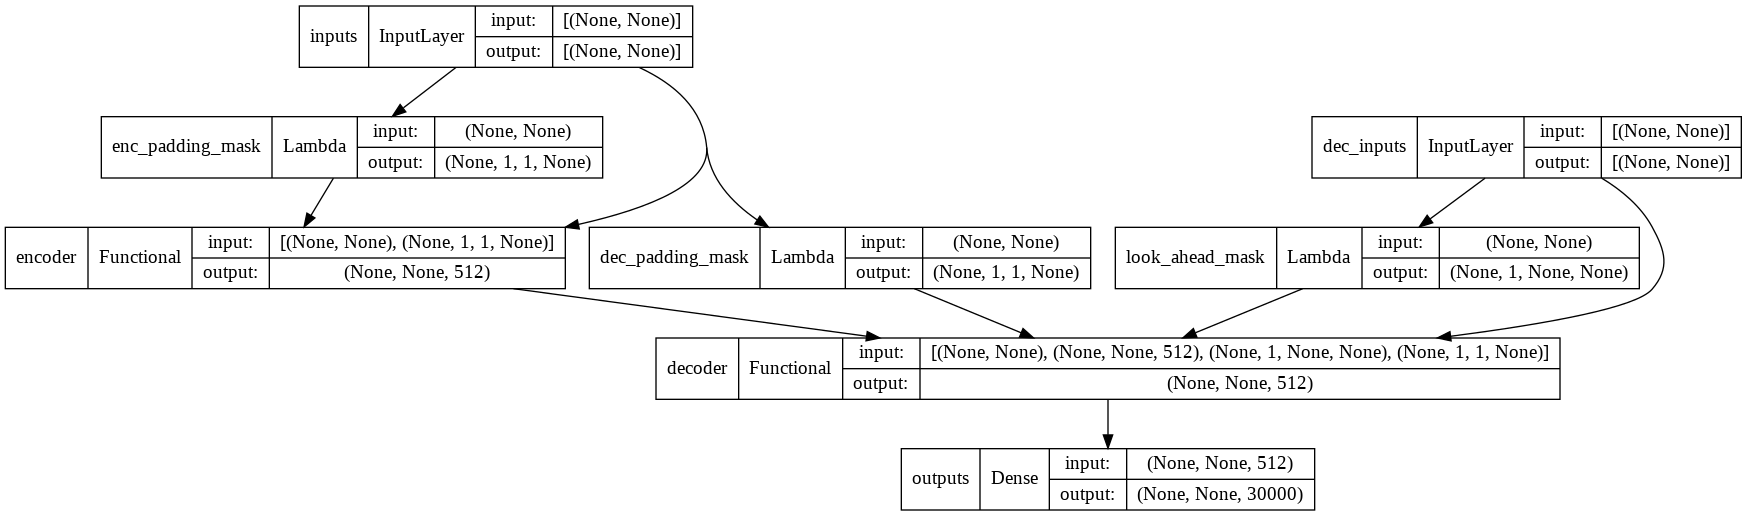

In [ ]:
test_transformer = transformer(num_layers=6, num_units=512, embedding_dim=512, num_heads=8, vocab_size=VOCAB_SIZE, dropout=0.3, name='test_transformer')
tf.keras.utils.plot_model(test_transformer, show_shapes=True)

## Training the Model

### Hyperparameters

In [ ]:
NUM_LAYERS = 6
NUM_UNITS = 512
EMBEDDING_DIM = 512
NUM_HEADS = 8
DROPOUT = 0.1
EPOCHS = 50

### Loss Function

In [ ]:
def compute_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, 15 - 1))
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')(y_true, y_pred)
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)
    return tf.reduce_mean(loss)

### Custom Learning Rate Scheduler

The paper uses the Adam optimizer with a custom learning rate scheduler.

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [ ]:
class LearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, embedding_dim, warmup_steps=4000):
        super(LearningRateSchedule, self).__init__()
        self.embedding_dim = tf.constant(embedding_dim, dtype=tf.float32)
        self.warmup_steps = warmup_steps

    def get_config(self):
        return {
            'embedding_dim': self.embedding_dim,
            'warmup_steps': self.warmup_steps
        }

    def __call__(self, step):
        return tf.math.multiply(tf.math.rsqrt(self.embedding_dim), tf.math.minimum(tf.math.rsqrt(step), step * (self.warmup_steps ** -1.5)))

Let's visualize how the custom learning rate scheduler changes the learning rate.

Text(0.5, 0, 'Steps')

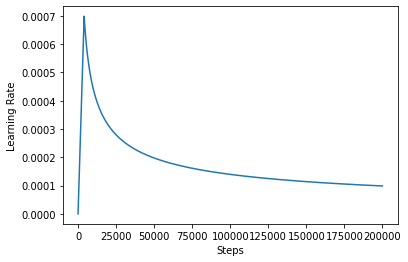

In [ ]:
test_learning_rate_schedule = LearningRateSchedule(embedding_dim=512)

plt.plot(test_learning_rate_schedule(tf.range(200000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Steps')

### Compiling and Training

In [ ]:
tf.keras.backend.clear_session()
learning_rate = LearningRateSchedule(EMBEDDING_DIM)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, 15 - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

with strategy.scope():
    model = transformer(num_layers=NUM_LAYERS, num_units=NUM_UNITS, embedding_dim=EMBEDDING_DIM, num_heads=NUM_HEADS, vocab_size=VOCAB_SIZE, dropout=DROPOUT)
    model.compile(optimizer=optimizer, loss=compute_loss, metrics=[accuracy])

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, None)]       0           []                               
                                                                                                  
 dec_inputs (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 enc_padding_mask (Lambda)      (None, 1, 1, None)   0           ['inputs[0][0]']                 
                                                                                                  
 encoder (Functional)           (None, None, 512)    24827904    ['inputs[0][0]',                 
                                                                  'enc_padding_mask[0][0

In [ ]:
model.fit(dataset, epochs=EPOCHS, validation_data=val_dataset)

Epoch 1/50
Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.


250/250 [==============================] - 156s 248ms/step - loss: 5.0287 - accuracy: 0.0688 - val_loss: 3.6509 - val_accuracy: 0.1193
Epoch 2/50
250/250 [==============================] - 42s 167ms/step - loss: 3.1074 - accuracy: 0.1342 - val_loss: 2.7674 - val_accuracy: 0.1592
Epoch 3/50
250/250 [==============================] - 42s 166ms/step - loss: 2.6423 - accuracy: 0.1702 - val_loss: 2.5122 - val_accuracy: 0.1793
Epoch 4/50
250/250 [==============================] - 42s 167ms/step - loss: 2.4626 - accuracy: 0.1828 - val_loss: 2.4127 - val_accuracy: 0.1862
Epoch 5/50
250/250 [==============================] - 43s 170ms/step - loss: 2.3606 - accuracy: 0.1901 - val_loss: 2.3604 - val_accuracy: 0.1908
Epoch 6/50
250/250 [==============================] - 42s 167ms/step - loss: 2.2829 - accuracy: 0.1962 - val_loss: 2.3336 - val_accuracy: 0.1930
Epoch 7/50
250/250 [==============================] - 42s 167ms/step - loss: 2.2144 - accuracy: 0.2016 - val_loss: 2.3129 - val_accuracy: 0.

Saving the model weights.

In [ ]:
model.save_weights('./saved_models/transformer-128k.h5', overwrite=True, save_format='h5')

In [ ]:
model.load_weights('./saved_models/transformer-128k.h5')

### Evaluating the Model

In [ ]:
def predict(sentence, max_length=20, padding_id=0):
    sentence = preprocess_sentence(sentence, fast_preprocessing=False)
    inputs = sentence_to_ids(sentence, tok2id)
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length, padding='post', value=padding_id)
    output = tf.expand_dims([tok2id['<START>']], 0)

    for i in range(max_length):
        predictions = model(inputs=[inputs, output], training=False)
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        if tf.equal(predicted_id, tok2id['<END>']):
            break
        output = tf.concat([output, predicted_id], axis=-1)
    
    output = tf.squeeze(output, axis=0)

    return ' '.join(ids_to_sentence(output[1:], id2tok))

In [ ]:
inputs = [
    'Hi',
    'Hey',
    'How are you?',
    'Tell me about yourself',
    'Do you love me?',
    "What's the meaning of life?",
    'How is the weather today?',
    "Let's have a dinner",
    'Are you a bot?',
    'Why not?'
]

for i, sentence in enumerate(inputs):
    result = predict(sentence)
    print(f"Test> {sentence}\nBot> {result}\n")

Test> Hi
Bot> hi .

Test> Hey
Bot> what ?

Test> How are you?
Bot> am fine .

Test> Tell me about yourself
Bot> about what ?

Test> Do you love me?
Bot> yes .

Test> What's the meaning of life?
Bot> the lingerie .

Test> How is the weather today?
Bot> good .

Test> Let's have a dinner
Bot> after that

Test> Are you a bot?
Bot> a little .

Test> Why not?
Bot> because i know you .



In [ ]:
sentence = train_dialogues[69][0]
for _ in range(5):
    result = predict(sentence)
    print(f"Test> {sentence}\nBot> {result}\n")
    sentence = result

Test> neurologist ? why ? what is wrong ?
Bot> nothing's wrong . they went to wellesley together .

Test> nothing's wrong . they went to wellesley together .
Bot> but if they call you upon our finals .

Test> but if they call you upon our finals .
Bot> that means i could learn from your mom .

Test> that means i could learn from your mom .
Bot> i guess i could teach you some things .

Test> i guess i could teach you some things .
Bot> okay .



## Summary

From the above results, it is very obvious that the model has been overfitted on the training corpus. But it has also learned the syntactics and grammar rules quite well even though some of the responses are not that meaningful. Since I included punctuations as well in the vocabulary, the model has learned right places to put punctuations at.

My initial approach was an attention based encoder-decoder model. Compared to this Transformer model, it was so slow to train and the results were not as good as in this model. By comparing with the results of the final evaluation procedure (i.e. feeding in the bot's output as input iteratively), the attention based encoder-decoder model gave the same results over and over again whereas the Transformer model did not.

Clearly, there're many improvements that can be made to this model. But I went with the original architecture that was used in the [paper](https://arxiv.org/abs/1706.03762).

## References

1. [Vaswani, Ashish & Shazeer, Noam & Parmar, et al., 2017. Attention Is All You Need.](https://arxiv.org/abs/1706.03762)
2. [The Illustrated Transformer - Jay Alammar](https://jalammar.github.io/illustrated-transformer/)
3. [Attention is all you need: Discovering the transformer paper](https://towardsdatascience.com/attention-is-all-you-need-discovering-the-transformer-paper-73e5ff5e0634)
4. [Yannic Kilcher Youtube Video – Attention is All You Need](https://www.youtube.com/watch?v=iDulh)
5. [Hedu - Math of Intelligence Youtube video - Visual Guide to Transformer Neural Networks](https://www.youtube.com/watch?v=dichIcUZfOw&t=0s)